# Transaction Fraud detection

# Набор данных Banksim
Мы выявляем мошеннические транзакции из набора данных Banksim. 
Этот синтетически созданный набор данных состоит из платежей от разных клиентов, произведенных в
разные периоды времени и с разными суммами. 

# Описание колонок
* Step: Означает день со старта симуляции (максимум 180, т.е примерно 6 месяцев).
* Customer: Идентификатор покупателя
* zipCodeOrigin: ZIP код покупателя
* Merchant: Идентификатор продавца
* zipMerchant: ZIP код продавца
* Age: категоризованный возраст
0: <= 18,
1: 19-25,
2: 26-35,
3: 36-45,
4: 46-55,
5: 56-65,
6: > 65
U: Неизвестно (Unknown)
* Gender: Gender for customer
E: Компания (Enterprise),
F: Женский (Female),
M: Мужской (Male,
U: Неизвестно (Unknown)
* Category: Категория покупки
* Amount: Объем транзакции
* Fraud: 1 (fraud, мошенничество), 0 (обычная транзакция)

Задание

1) Проведите первичный анализ данных, сформулируйте эвристики для детекции фрода (аномалий), которые можно использовать в качестве базового решения. Приведите метрики качества для оценки вашего алгоритма.

2) Попробуйте получить решение лучше по метрикам (с помощью модели ML), чем эвристика, помните, что класс 1 (мошенничество) в целом скорее важнее, чем класс 0.

3) Изучите одну из техник балансировки выборки (например, оверсемплинг с помощью метода SMOTE) и попробуйте еще улучшить качество алгоритма.

4) Выберите лучший алгоритм по пунктам 1-2-3 и внесите часть тестовой выборки (с предсказанием) в вашу учебную базу, а затем постройте дэшборд в redash в котором будет отражена информация о количестве фродовых транзакций за неделю, а также будут выведены последние 10 фродовых транзакций, требующих проверки.


https://sato-1.ru/pediatric-otolaryngologists/vysokoe-kolichestvo-froda-chto-takoe-frod-v-mobilnoi-reklame/

https://www.kaggle.com/code/turkayavci/fraud-detection-on-bank-payments

In [3]:
import pandas as pd
import numpy as np
import csv
import sqlite3
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, roc_auc_score, roc_curve, precision_score, recall_score, f1_score, precision_recall_curve

from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task
import warnings
warnings.filterwarnings("ignore")

In [2]:
df=pd.read_csv('bs140513_032310.csv',quotechar="'", quoting=csv.QUOTE_NONNUMERIC)
df.head(5)

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0.0,C1093826151,4,M,28007.0,M348934600,28007.0,es_transportation,4.55,0.0
1,0.0,C352968107,2,M,28007.0,M348934600,28007.0,es_transportation,39.68,0.0
2,0.0,C2054744914,4,F,28007.0,M1823072687,28007.0,es_transportation,26.89,0.0
3,0.0,C1760612790,3,M,28007.0,M348934600,28007.0,es_transportation,17.25,0.0
4,0.0,C757503768,5,M,28007.0,M348934600,28007.0,es_transportation,35.72,0.0


## Первичный анализ

#### Вспомогательные функции

##### Функция зависимости фрод трансакций к общему количеству трансакций для категории, передаваемой в параметрах (_perc), и зависимости фрод трансакций категории к общему количествоу фрод трансакций(perc_all)

In [63]:
def get_fraud_perc(column, df, df_fraud, ascending = False):
    df_fraud = df_fraud[[column, 'fraud']].groupby(column).count().sort_values(by=['fraud'], ascending = False)
    df_all = df[[column, 'fraud']].groupby(column).count().sort_values(by=['fraud'], ascending = False)
    df_perc = df_all.merge(df_fraud, on = column,how='left', suffixes=('_all', '_'))
    df_perc[f'{column}'+'_perc'] = df_perc.fraud_ / df_perc.fraud_all
    df_perc[f'{column}'+'_perc_all'] = df_perc.fraud_ / df_fraud.fraud.sum()

    return df_perc.fillna(0)

##### Функция для графиков

In [64]:
def make_bar_plot(title, x, y,xlabel,ylabel, color = 'navy'):
    plt.figure(figsize=(15,7))
    plt.style.use('ggplot')
    plt.bar(x, y, color= color)
    plt.xlabel(xlabel,fontsize=14)
    plt.ylabel(ylabel,fontsize=14)
    plt.title(title)
    plt.show()

def make_barh_plot(title, x, y,xlabel, ylabel, color = 'navy', figsize=(20,7)):
    plt.figure(figsize=figsize)
#     plt.style.use('ggplot')
    plt.barh(x, y, color= color)
    plt.title(title)
    plt.xlabel(xlabel,fontsize=14)
    plt.ylabel(ylabel,fontsize=14)
    plt.show()

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594643 entries, 0 to 594642
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   step         594643 non-null  float64
 1   customer     594643 non-null  object 
 2   age          594643 non-null  object 
 3   gender       594643 non-null  object 
 4   zipcodeOri   594643 non-null  float64
 5   merchant     594643 non-null  object 
 6   zipMerchant  594643 non-null  float64
 7   category     594643 non-null  object 
 8   amount       594643 non-null  float64
 9   fraud        594643 non-null  float64
dtypes: float64(5), object(5)
memory usage: 45.4+ MB


In [66]:
df.isnull().sum()

step           0
customer       0
age            0
gender         0
zipcodeOri     0
merchant       0
zipMerchant    0
category       0
amount         0
fraud          0
dtype: int64

In [67]:
df_fraud = df[df.fraud == 1]
df_nonfraud = df[df.fraud == 0]

Количество фрод операций значительно меньше, чем нефрод, то есть выборка ожидаемо несбалансированная


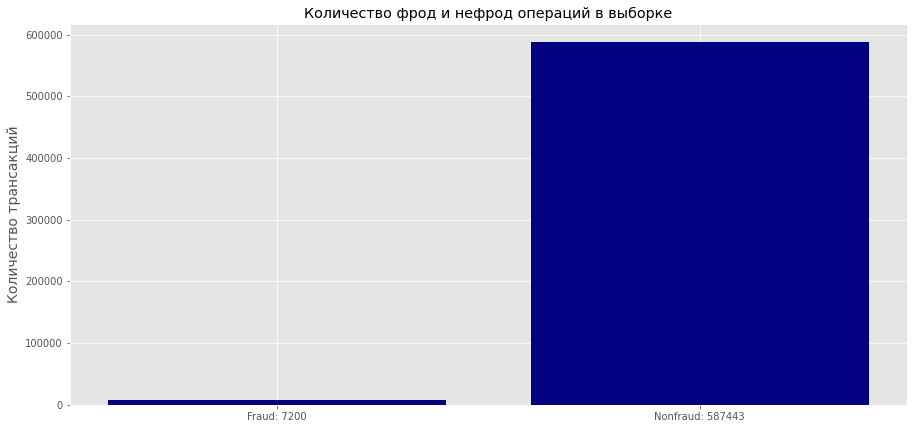

Отношение фрод трансакций к общему числу трансакций: 1.21%


In [68]:
x = [f'Fraud: {len(df_fraud)}', f'Nonfraud: {len(df_nonfraud)}']
y = [len(df_fraud), len(df_nonfraud)]
make_bar_plot("Количество фрод и нефрод операций в выборке", x, y, "", "Количество трансакций")

print(f'Отношение фрод трансакций к общему числу трансакций: {round(len(df_fraud)/len(df)*100, 2)}%', )

#### Зависимость от категории трат.
Мы видим, что в таких категориях как es_contents, es_food, es_transportation нет ни одной фрод трансакци.
Наиболее скомпромитированные категории в абсолютном значении- это es_sportsandtoys и es_health

In [69]:
df_cat = get_fraud_perc('category', df, df_fraud, True)
df_cat

,fraud_all,fraud_,category_perc,category_perc_all
category,,,,
es_transportation,505119,0.0,0.000000,0.000000
es_food,26254,0.0,0.000000,0.000000
es_health,16133,1696.0,0.105126,0.235556
es_wellnessandbeauty,15086,718.0,0.047594,0.099722
es_fashion,6454,116.0,0.017973,0.016111
es_barsandrestaurants,6373,120.0,0.018829,0.016667
es_hyper,6098,280.0,0.045917,0.038889
es_sportsandtoys,4002,1982.0,0.495252,0.275278
es_tech,2370,158.0,0.066667,0.021944


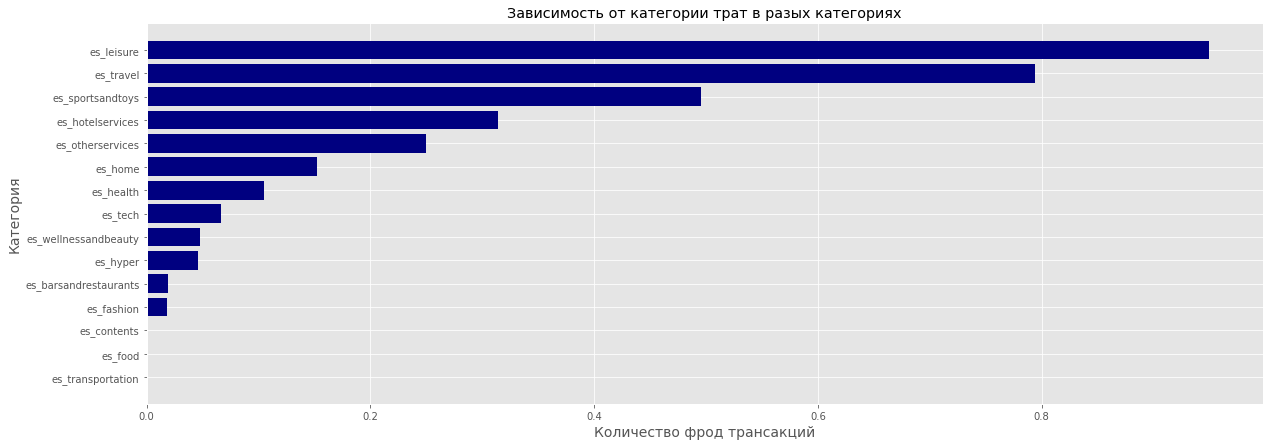

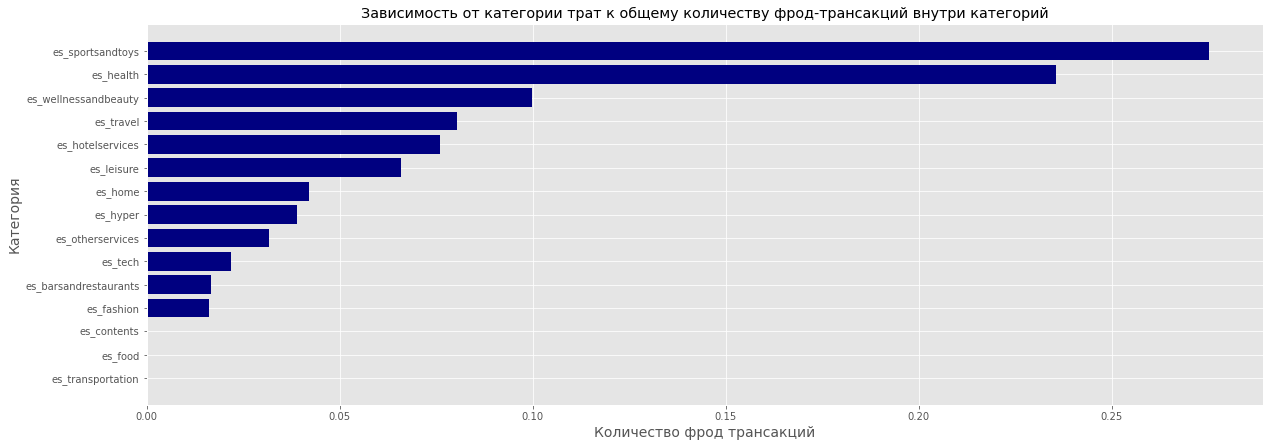

In [70]:
make_barh_plot("Зависимость от категории трат в разых категориях", df_cat.sort_values(by='category_perc').index, df_cat.sort_values(by='category_perc').category_perc, "Количество фрод трансакций", "Категория")
make_barh_plot("Зависимость от категории трат к общему количеству фрод-трансакций внутри категорий", df_cat.sort_values(by='category_perc_all').index, df_cat.sort_values(by='category_perc_all').category_perc_all, "Количество фрод трансакций", "Категория")

Если  берем количество фрод трансакций в каждой категории трат по отношению 
ко всему объему в категориях, то получаются такие результаты:
В категориях es_fashion, es_barsandrestaurants, es_hyper, es_wellnessandbeauty и es_tech меньше 7 %
В категориях  es_leisure почти все трансакции фродовые, в категории es_travel - большинство

Если рассматривает долю фрод трансакций к общему количеству фрода, то больше всего в значениях es_sportsandtoys, es_health,es_wellnessandbeauty

#### Зависимость размера  трат

Максимальный объема нефрод единовременной трансакции составляет 2144.86.
То есть, если мы обнаруживаем у клиента больший объем единовременной трансакции,то это будет скорее всего фрод-трансакция.
Все нулевые трансакции - не фрод.

Разделим фрейм согласно объему трансакций на части от 0 до 5000. Рассмотрим, какой объем фрод операций в каждой части. Обнаружим, что основной объем трансакций лежит в диапазоне до 1000 уе. Большинство  трансакций больше 750 уе - фрод трансакции. В диапазоне от 500 до 700 трансакций размер фрод трансакций в два раза больше нефрод 

In [71]:
amount = ['0-100', '100-200','200-300', '300-400','400-500', '500-750', '750-1000', '1000-']
df_amount_fraud = df_fraud.copy()
df_amount_fraud['chunk'] = pd.cut(df_amount_fraud.amount, [0, 100,200, 300,400, 500, 750, 1000, 5000], 
                           labels=amount,
                           right=False, 
                           include_lowest=True)
df_amount_all = df.copy()
df['chunk'] = pd.cut(df_amount_all.amount, [0, 100,200, 300,400, 500, 750, 1000, 5000], 
                           labels=amount,
                           right=False, 
                           include_lowest=True)

In [72]:
df_amount = get_fraud_perc('chunk', df, df_amount_fraud).sort_values(by='chunk')
df_amount

,fraud_all,fraud_,chunk_perc,chunk_perc_all
chunk,,,,
0-100,574082,1139,0.001984,0.159501
100-200,12917,1106,0.085624,0.154880
200-300,3367,1144,0.339768,0.160202
300-400,1401,1065,0.760171,0.149139
400-500,712,670,0.941011,0.093824
500-750,1080,1050,0.972222,0.147038
750-1000,446,419,0.939462,0.058675
1000-,579,548,0.946459,0.076740


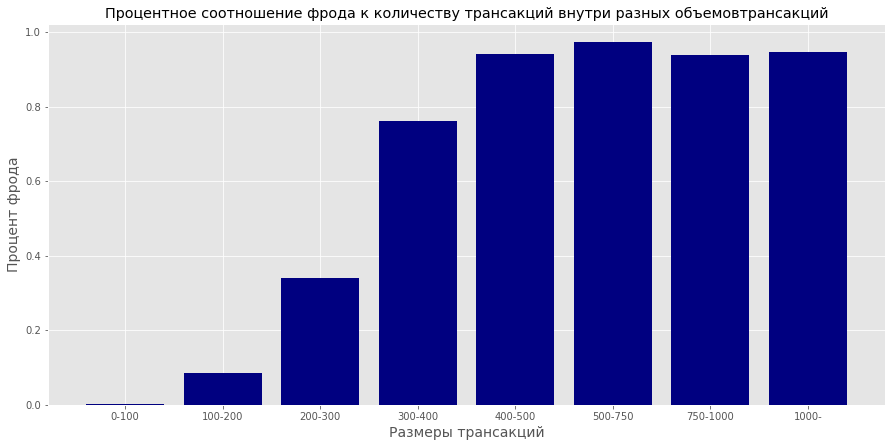

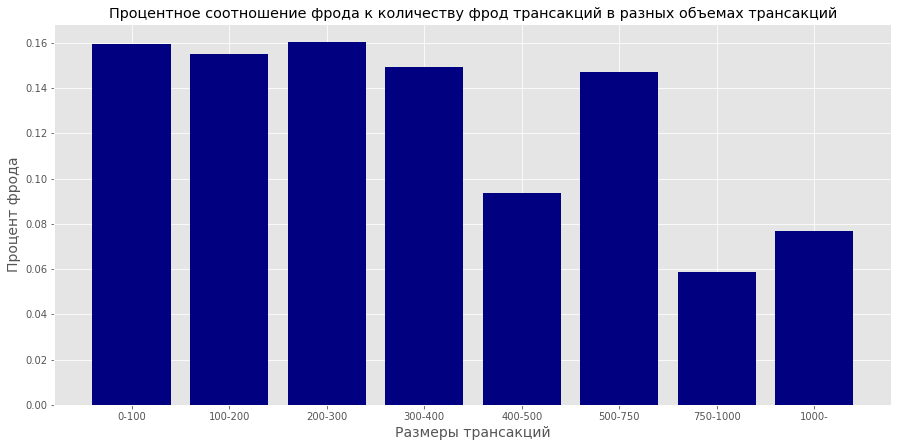

In [73]:
make_bar_plot("Процентное соотношение фрода к количеству трансакций внутри разных объемовтрансакций",
              df_amount.index,
              df_amount.chunk_perc,
              "Размеры трансакций",
              "Процент фрода")
make_bar_plot("Процентное соотношение фрода к количеству фрод трансакций в разных объемах трансакций",
              df_amount.index,
              df_amount.chunk_perc_all,
              "Размеры трансакций",
              "Процент фрода")

#### Зависимость от возраста

В абсолютном значении наиболее часто встечается фрод операции в возрастной категории 2: 26-35 лет.
Но если посчитать процентное соотношение всех трансакций в каждой категории к количеству фрода, то получается, что больший процента в возрасте  <= 18. 
В целом, этот параметр не очень информативный, тк даже в категории "до 18" процентное соотношение фрода - всего ок. 2%

In [74]:
df_age = get_fraud_perc('age', df, df_fraud).sort_values(by='age')
df_age

,fraud_all,fraud_,age_perc,age_perc_all
age,,,,
0,2452,48,0.019576,0.006667
1,58131,689,0.011853,0.095694
2,187310,2344,0.012514,0.325556
3,147131,1755,0.011928,0.243750
4,109025,1410,0.012933,0.195833
5,62642,686,0.010951,0.095278
6,26774,261,0.009748,0.036250
U,1178,7,0.005942,0.000972


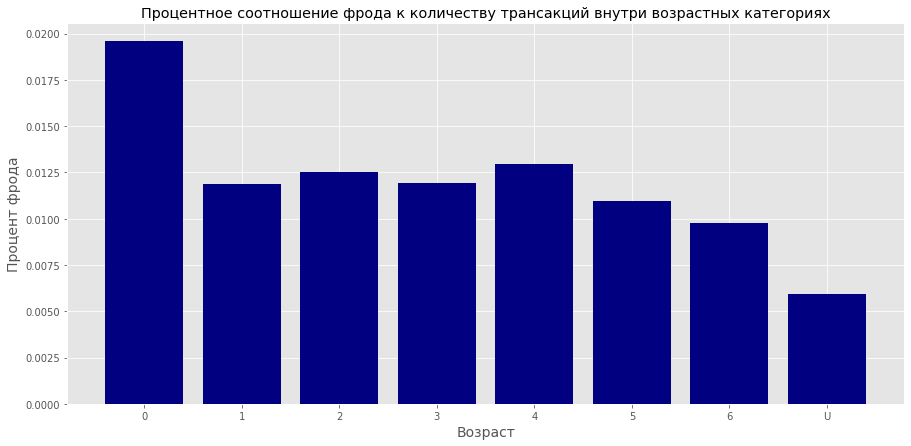

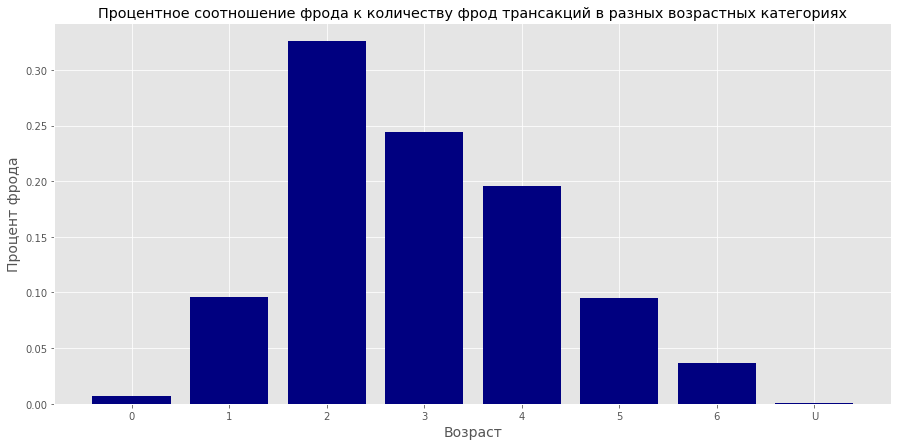

In [75]:
make_bar_plot("Процентное соотношение фрода к количеству трансакций внутри возрастных категориях",
              df_age.index,
              df_age.age_perc,
              "Возраст",
              "Процент фрода")
make_bar_plot("Процентное соотношение фрода к количеству фрод трансакций в разных возрастных категориях",
              df_age.index,
              df_age.age_perc_all,
              "Возраст",
              "Процент фрода")

#### Зависимость от пола
Количество фрод трансакций у категории  E: Компания (Enterprise) в абсолютном и процентном соотношении пренебрежимо невелика. 

В остальном этот параметр также как и возраст не очень информативный

In [76]:
df_gender = get_fraud_perc('gender', df, df_fraud)
df_gender

,fraud_all,fraud_,gender_perc,gender_perc_all
gender,,,,
F,324565,4758.0,0.014660,0.660833
M,268385,2435.0,0.009073,0.338194
E,1178,7.0,0.005942,0.000972
U,515,0.0,0.000000,0.000000


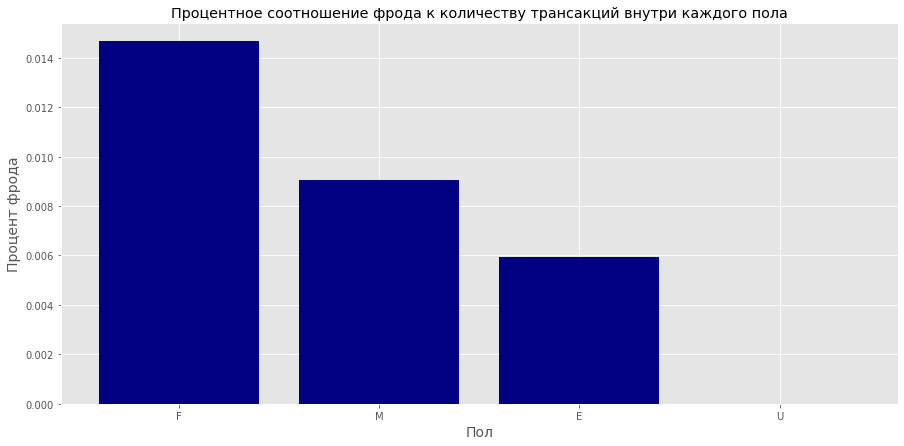

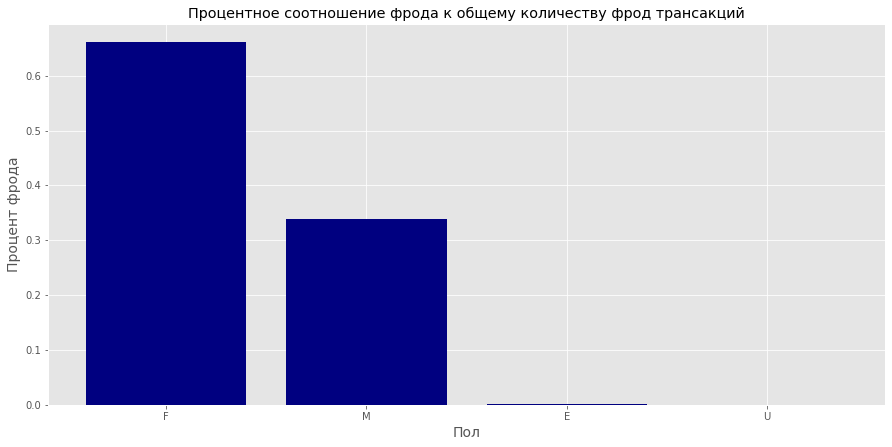

In [77]:
make_bar_plot("Процентное соотношение фрода к количеству трансакций внутри каждого пола", 
              df_gender.index, 
              df_gender.gender_perc,
              "Пол",
              "Процент фрода")

make_bar_plot("Процентное соотношение фрода к общему количеству фрод трансакций для каждого пола", 
              df_gender.index, 
              df_gender.gender_perc_all,
              "Пол",
              "Процент фрода")

#### Зависимость от продавца

Если посмотреть на продавцов и отношение всех трансакций к количеству фрода, то есть те продавцы, трансакции к которым практически все являются фродом, а также есть те, у которых они минимальны.

In [78]:
df_merch = get_fraud_perc('merchant', df, df_fraud, True)
df_merch

,fraud_all,fraud_,merchant_perc,merchant_perc_all
merchant,,,,
M1823072687,299693,0.0,0.000000,0.000000
M348934600,205426,0.0,0.000000,0.000000
M85975013,26254,0.0,0.000000,0.000000
M1053599405,6821,0.0,0.000000,0.000000
M151143676,6373,120.0,0.018829,0.016667
M855959430,6098,280.0,0.045917,0.038889
M1946091778,5343,0.0,0.000000,0.000000
M1913465890,3988,0.0,0.000000,0.000000
M209847108,3814,106.0,0.027792,0.014722


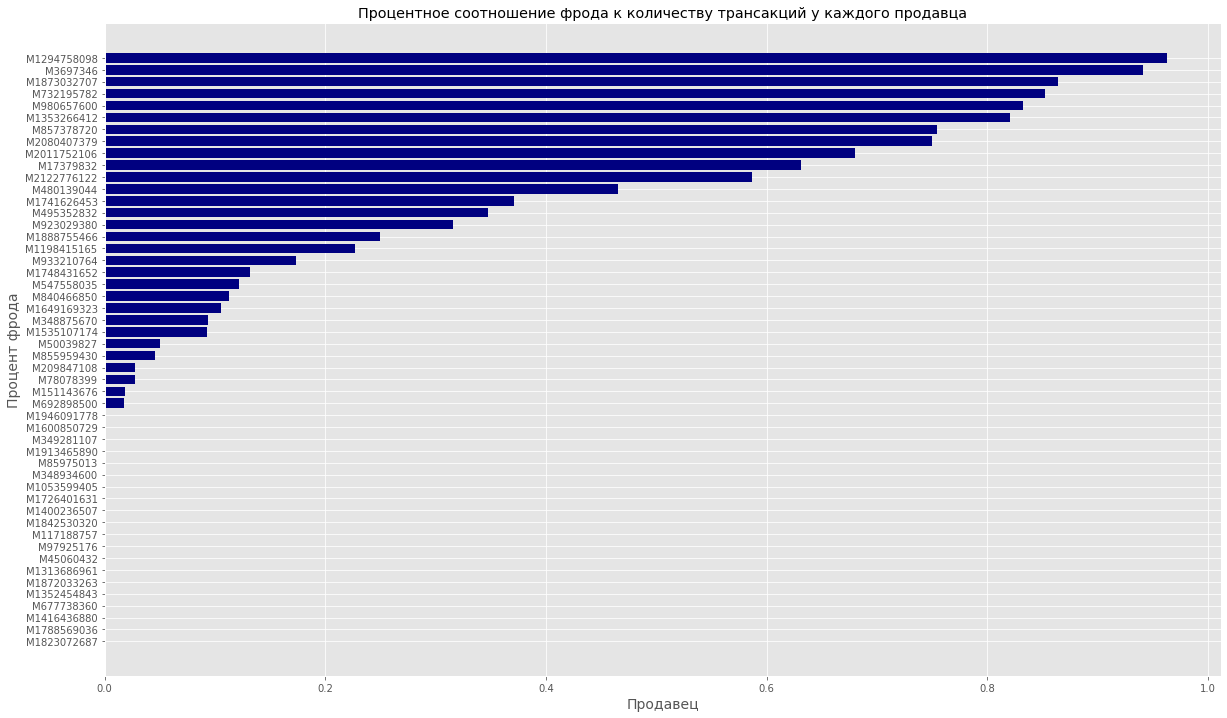

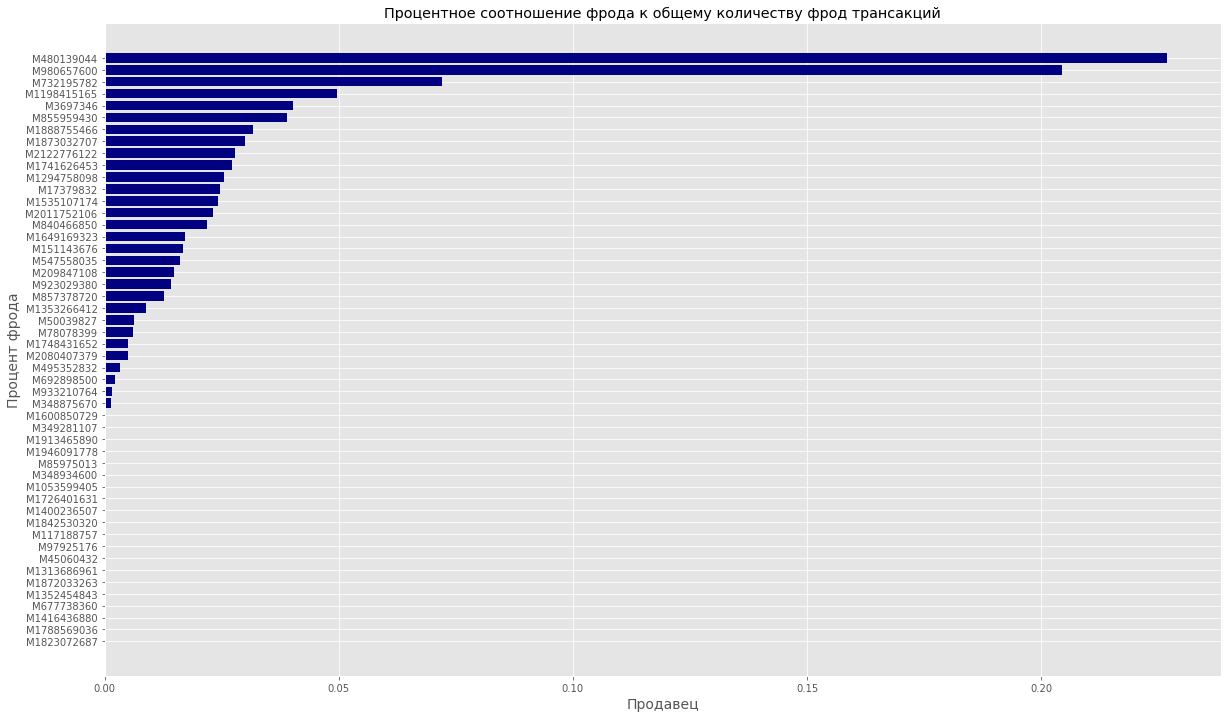

In [79]:
make_barh_plot("Процентное соотношение фрода к количеству трансакций у каждого продавца", 
              df_merch.sort_values(by='merchant_perc').index, 
              df_merch.sort_values(by='merchant_perc').merchant_perc,
              "Продавец",
              "Процент фрода",
               figsize = (20,12))
make_barh_plot("Процентное соотношение фрода к общему количеству фрод трансакций",
              df_merch.sort_values(by='merchant_perc_all').index, 
              df_merch.sort_values(by='merchant_perc_all').merchant_perc_all,
              "Продавец",
              "Процент фрода",
               figsize = (20,12))



In [80]:
print(f'У {round(len(df_merch[df_merch.fraud_ == 0 ])/len(df_merch), 3) * 100}% продавцов выборки нет фрод трансакций')

У 40.0% продавцов выборки нет фрод трансакций


#### Зависимость от клиента
Если посмотреть на клиентов и отношение всех трансакций к количеству фрода, то есть те клиенты, трансакции к которым практически все являются фродом, а также есть те, к которых они минимальны.

In [81]:
df_cust = get_fraud_perc('customer', df, df_fraud, True)
df_cust

,fraud_all,fraud_,customer_perc,customer_perc_all
customer,,,,
C1978250683,265,110.0,0.415094,0.015278
C1275518867,252,114.0,0.452381,0.015833
C806399525,237,125.0,0.527426,0.017361
C515668508,205,44.0,0.214634,0.006111
C1338396147,195,16.0,0.082051,0.002222
...,...,...,...,...
C1156745710,6,1.0,0.166667,0.000139
C1345586046,6,1.0,0.166667,0.000139
C1743702978,5,1.0,0.200000,0.000139


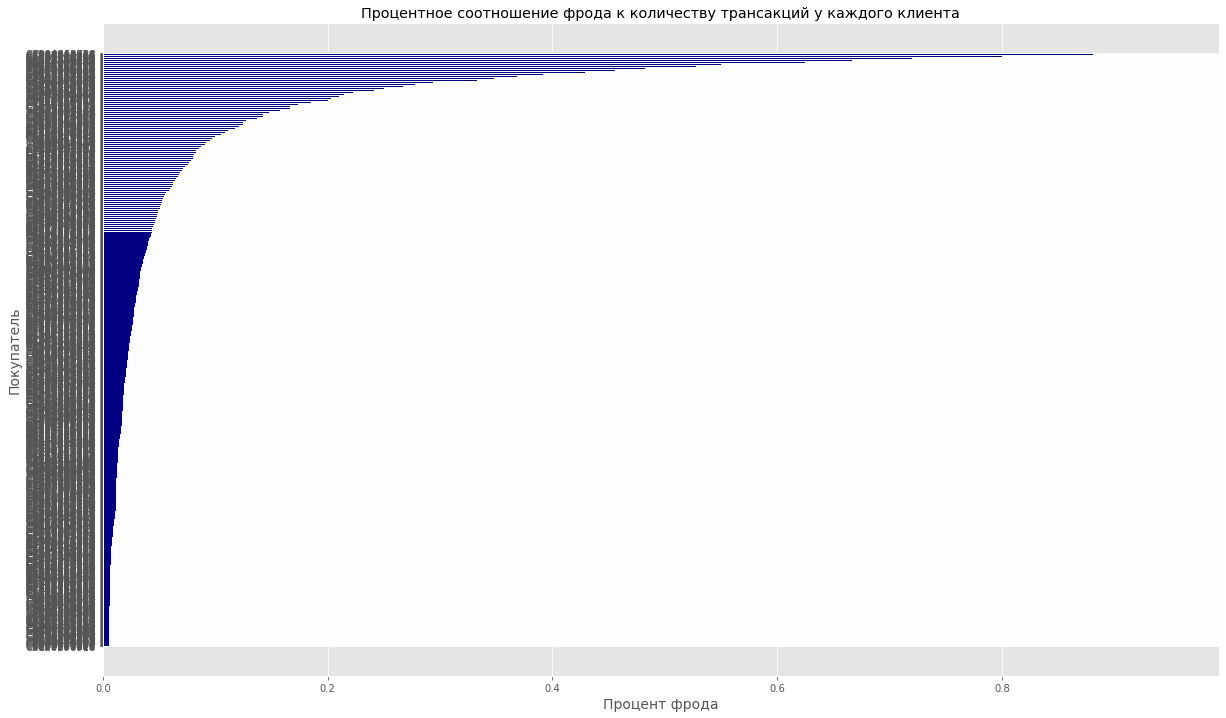

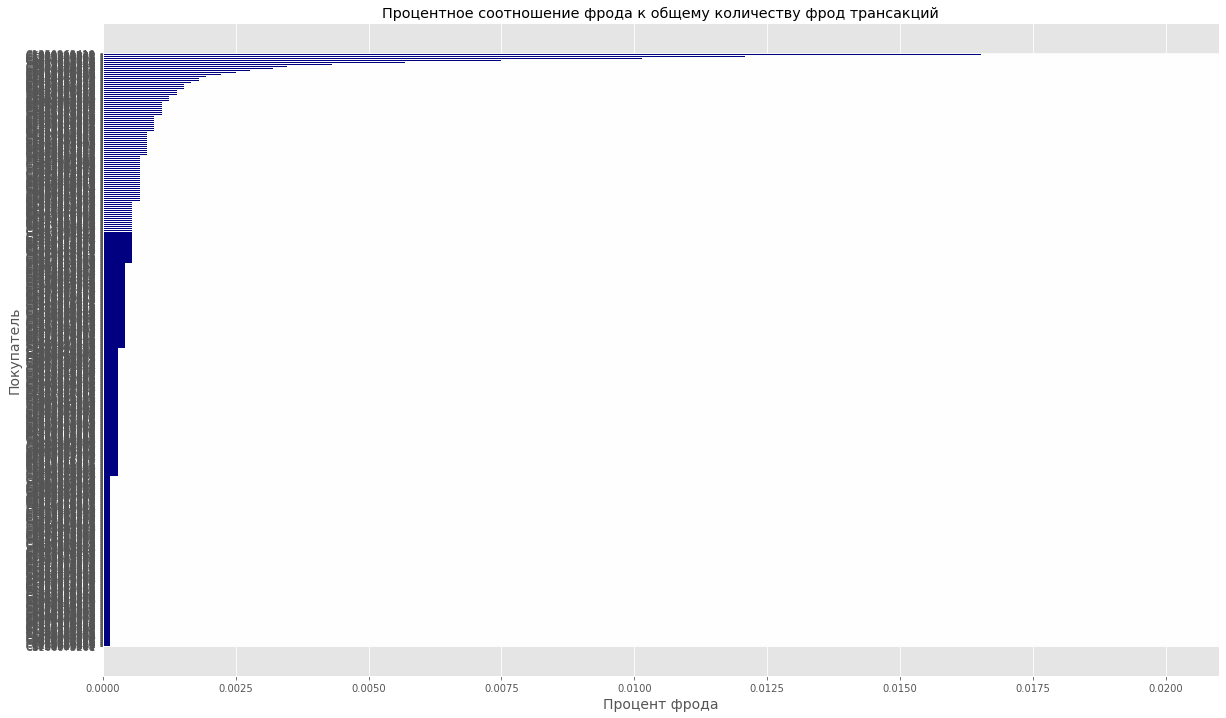

In [82]:
make_barh_plot("Процентное соотношение фрода к количеству трансакций у каждого клиента", 
              df_cust[df_cust.customer_perc > 0].sort_values(by='customer_perc').index, 
              df_cust[df_cust.customer_perc > 0].sort_values(by='customer_perc').customer_perc,
              "Процент фрода",
               "Покупатель",
               figsize = (20,12))
make_barh_plot("Процентное соотношение фрода к общему количеству фрод трансакций",
              df_cust[df_cust.customer_perc_all > 0].sort_values(by='customer_perc_all').index, 
              df_cust[df_cust.customer_perc_all > 0].sort_values(by='customer_perc_all').customer_perc_all,
              "Процент фрода",
               "Покупатель",
               figsize = (20,12))


In [83]:
print(f'У {round(len(df_cust[df_cust.fraud_ == 0 ])/len(df_cust), 3) * 100}% клиентов выборки нет фрод трансакций')

У 63.9% клиентов выборки нет фрод трансакций


#### Зависимость от дня
Предполагала, что возможно есть дни, в которых есть всплески фрод активностей. Но в этих синтетичесих данных каждый день случается 40 фрод трансакций

In [14]:
df_step = get_fraud_perc('step', df, df_fraud)
print(df_step.fraud_.unique())

[40]


## Базовое решение

In [87]:
#Создадим новый скопированный фрейм, чтобы не модифицировать исходный, по умолчанию зададим нами предсказанное
# фрод значение = 0
df_basic = df.copy()
df_basic['fraud_basic'] = 0
# Задаем характеристику для каждой фичи. Поумолчанию задаем 0
# Берем только 4, гендер и возраст не учитываю, так как они никак не влияют на итоговый результат

df_basic['merch_w'] = 0
df_basic['cust_w'] = 0
df_basic['cat_w'] = 0
df_basic['amount_w'] = 0

#Определяем для каждой фичи положительное значение, при соответствии условиям:
# а) У клиента был случай фрода
# б) У продавца был случай фрода
# с) У категории был случай фрода
# д) Объем трансакции выше 500 (на что приходится большая часть фрод трансакций)
 
df_basic.loc[df_basic['customer'].isin(df_cust[df_cust.fraud_ > 0].index), 'cust_w'] = 1
df_basic.loc[df_basic['merchant'].isin(df_merch[df_merch.fraud_ > 0].index), 'merch_w'] = 1
df_basic.loc[df_basic['category'].isin(df_cat[df_cat.fraud_ > 0].index), 'cat_w'] = 1
df_basic.loc[df_basic['amount'] >= 500, 'amount_w'] = 1



# Коэффициент соответствует примерной важности параметров для итогового результата
df_basic['res']=(df_basic.merch_w*0.4
                 + df_basic.cust_w*0.4
                  + df_basic.cat_w*0.1
                  + df_basic.amount_w*0.1
                )

In [88]:
df_basic[(df_basic.fraud == 1) & (df_basic.res > 0)].describe().round(4)

,step,zipcodeOri,zipMerchant,amount,fraud,fraud_basic,merch_w,cust_w,cat_w,amount_w,res
count,7200.0000,7200.0,7200.0,7200.0000,7200.0,7200.0,7200.0,7200.0,7200.0,7200.0000,7200.0000
mean,89.5000,28007.0,28007.0,530.9266,1.0,0.0,1.0,1.0,1.0,0.2883,0.9288
std,51.9643,0.0,0.0,835.5871,0.0,0.0,0.0,0.0,0.0,0.4530,0.0453
min,0.0000,28007.0,28007.0,0.0300,1.0,0.0,1.0,1.0,1.0,0.0000,0.9000
25%,44.7500,28007.0,28007.0,159.9800,1.0,0.0,1.0,1.0,1.0,0.0000,0.9000
50%,89.5000,28007.0,28007.0,319.1750,1.0,0.0,1.0,1.0,1.0,0.0000,0.9000
75%,134.2500,28007.0,28007.0,548.9775,1.0,0.0,1.0,1.0,1.0,1.0000,1.0000
max,179.0000,28007.0,28007.0,8329.9600,1.0,0.0,1.0,1.0,1.0,1.0000,1.0000


In [89]:
df_basic[(df_basic.fraud == 0) & (df_basic.res > 0)].describe()

,step,zipcodeOri,zipMerchant,amount,fraud,fraud_basic,merch_w,cust_w,cat_w,amount_w,res
count,201048.000000,201048.0,201048.0,201048.000000,201048.0,201048.0,201048.000000,201048.000000,201048.000000,201048.000000,201048.000000
mean,98.817506,28007.0,28007.0,40.184696,0.0,0.0,0.146776,0.828708,0.274487,0.000438,0.417686
std,50.787097,0.0,0.0,46.384128,0.0,0.0,0.353883,0.376765,0.446256,0.020917,0.165776
min,0.000000,28007.0,28007.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.100000
25%,57.000000,28007.0,28007.0,15.020000,0.0,0.0,0.000000,1.000000,0.000000,0.000000,0.400000
50%,103.000000,28007.0,28007.0,29.550000,0.0,0.0,0.000000,1.000000,0.000000,0.000000,0.400000
75%,143.000000,28007.0,28007.0,48.540000,0.0,0.0,0.000000,1.000000,1.000000,0.000000,0.400000
max,179.000000,28007.0,28007.0,2144.860000,0.0,0.0,1.000000,1.000000,1.000000,1.000000,1.000000


In [90]:
df_basic.loc[df_basic['res'] >=0.9, 'fraud_basic'] = 1


In [91]:
print("Количество ложноположительных результатов: ", end = '')
print(len(df_basic[(df_basic.fraud_basic == 1) & (df_basic.fraud == 0)]))
print("Количество ложноотрицательных результатов: ", end = '')
print(len(df_basic[(df_basic.fraud_basic == 0) & (df_basic.fraud == 1)]))

Количество ложноположительных результатов: 14484
Количество ложноотрицательных результатов: 0


## Preprocessing

В качестве target используется колонка fraud. Она бинарная, поэтому буду использовать ее без изменения

In [32]:
# В данной выборке все значения столбца zipcodeOri и zipMerchant = 28007.
# Поэтому можем избавиться от них
print(df.zipcodeOri.unique())
print(df.zipMerchant.unique()
     )

[28007.]
[28007.]


In [33]:
df.drop(['zipMerchant', 'zipcodeOri'], axis=1, inplace=True)

In [34]:
#переведем все колонки типа object в числовые
cols = df.select_dtypes(include= ['object']).columns
for col in cols:
    df[col] = df[col].astype('category')
df[cols] = df[cols].apply(lambda x: x.cat.codes)

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594643 entries, 0 to 594642
Data columns (total 8 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   step      594643 non-null  float64
 1   customer  594643 non-null  object 
 2   age       594643 non-null  int64  
 3   gender    594643 non-null  int64  
 4   merchant  594643 non-null  object 
 5   category  594643 non-null  object 
 6   amount    594643 non-null  float64
 7   fraud     594643 non-null  float64
dtypes: float64(3), int64(2), object(3)
memory usage: 36.3+ MB


## Prediction

In [27]:
def make_roc_curve_plot(fpr_test, tpr_test, fpr_train, tpr_train):
    plt.figure(figsize=(5, 3.5))
    plt.plot([0, 1], label="Baseline", linestyle='--')
    plt.plot(fpr_test, tpr_test, label='train')
    plt.plot(fpr_train, tpr_train, label='test')
    plt.title('ROC Curve')
    plt.xlabel('TPR')
    plt.ylabel('FPR')
    plt.legend(loc = 4)
    plt.show();
    
def make_prediction(df, random_state = 777):
    df_train, df_test = train_test_split(df, test_size=0.2, random_state=random_state)
    task = Task(name='binary' ) # здесь задается тип решаемой задачи
    roles = {'target': 'fraud'} # здесь задается название целевого признака 
    automl = TabularAutoML(task=task, timeout=3600, memory_limit=10) # здесь создаем объект черной коробки LightAutoML
    oof_pred = automl.fit_predict(df_train, roles=roles)

    y_train = df_train['fraud']
    y_test = df_test['fraud']
    df_test_test = df_test.drop('fraud',axis=1)
    df_train = df_train.drop('fraud',axis=1)    

    y_train_score = automl.predict(df_train).data
    y_test_score = automl.predict(df_test_test).data
    print('Gini_train:', 2*roc_auc_score(y_train, y_train_score)-1)
    print('Gini_test:', 2*roc_auc_score(y_test, y_test_score)-1)

    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_score) 
    optimal_idx = np.argmax(tpr_test - fpr_test) 
    optimal_threshold = thresholds_test[optimal_idx]
    print('optimal_threshold: ', optimal_threshold)
    fraud_basic = np.where(y_test_score>optimal_threshold, 1,0)
    df_test['fraud_basic'] = fraud_basic
    
    fpr_train, tpr_train, thresholds_train = roc_curve(y_test, y_test_score) 
    make_roc_curve_plot(fpr_test, tpr_test, fpr_train, tpr_train)

    return df_test

Gini_train: 0.9984780196276895
Gini_test: 0.9975706118114132


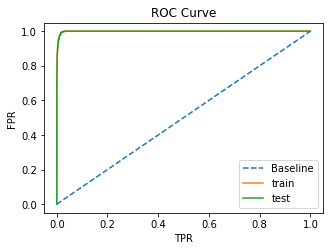

In [25]:
df_test =  make_prediction(df, random_state = 777)

In [26]:
print("Количество ложноположительных результатов: ", end = '')
print(len(df_test[(df_test.fraud_basic == 1) & (df_test.fraud == 0)]))
print("Количество ложноотрицательных результатов: ", end = '')
print(len(df_test[(df_test.fraud_basic == 0) & (df_test.fraud == 1)]))

Количество ложноположительных результатов: 2394
Количество ложноотрицательных результатов: 7


In [20]:
len(df_test[(df_test.fraud_basic == 1) & (df_test.fraud == 0)])/len(df_test)*100

2.0163290702856327

In [28]:
automl.get_feature_scores()

,Feature,Importance
0,amount,226278.858319
1,merchant,57230.306353
2,category,35959.463965
3,customer,15626.839403
4,step,12453.857836
5,age,2626.175654
6,gender,852.215438


### Балансировка выборки

In [29]:
from imblearn.over_sampling import SMOTE 

Gini_train: 0.9999955358573673
Gini_test: 0.9999619006443481
optimal_threshold:  0.48609746


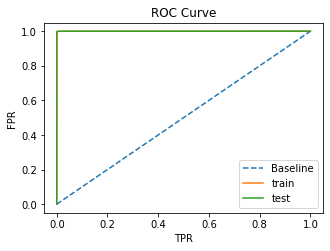

In [36]:
sm = SMOTE(random_state=777)
X_res, y_res = sm.fit_resample(df.drop('fraud', axis = 1), df['fraud'])
X_res['fraud'] = y_res
df_test_smote = make_prediction(X_res)

In [38]:
print("Количество ложноположительных результатов: ", end = '')
print(len(df_test_smote[(df_test_smote.fraud_basic == 1) & (df_test_smote.fraud == 0)]))
print("Количество ложноотрицательных результатов: ", end = '')
print(len(df_test_smote[(df_test_smote.fraud_basic == 0) & (df_test_smote.fraud == 1)]))

Количество ложноположительных результатов: 157
Количество ложноотрицательных результатов: 243


### Save to BD

In [39]:
conn = sqlite3.connect('test_database') 
c = conn.cursor()

In [42]:
c.execute("""
          CREATE TABLE IF NOT EXISTS prediction
          ([step] NUMERIC, 
           [customer]  VARCHAR(255),
           [age] INTEGER,
           [gender] INTEGER,
           [merchant]  VARCHAR(255),
           [category]  VARCHAR(255),
           [amount] NUMERIC,
           [fraud] INTEGER,
           [chunk]  VARCHAR(255),
           [fraud_basic] INTEGER
           )
          """)
                     
conn.commit()

In [51]:
df_test.to_sql('prediction', conn, if_exists='append', index = False)


ProgrammingError: Cannot operate on a closed database.

In [49]:
conn.close()

In [56]:
conn = sqlite3.connect('test_database')
c = conn.cursor()
df = pd.io.sql.read_sql("""select * from prediction""", conn)
len(df[df.fraud_basic == 1])
df

,step,customer,age,gender,merchant,category,amount,fraud,chunk,fraud_basic
0,102,C623466885,3,F,M1823072687,es_transportation,66.05,0,None,0
1,57,C1561544871,1,M,M348934600,es_transportation,35.33,0,None,0
2,108,C875898611,3,F,M348934600,es_transportation,21.04,0,None,0
3,78,C1980965530,4,M,M348934600,es_transportation,37.03,0,None,0
4,148,C576358551,6,M,M348934600,es_transportation,4.92,0,None,0
...,...,...,...,...,...,...,...,...,...,...
118924,27,C2035771335,2,F,M348934600,es_transportation,17.59,0,None,0
118925,122,C1187702596,3,M,M1823072687,es_transportation,9.15,0,None,0
118926,75,C899204870,3,M,M348934600,es_transportation,43.95,0,None,0
118927,120,C458379262,5,F,M1823072687,es_transportation,3.75,0,None,0
